# BERT Trading Signal: News and Corporate Actions

```bibtex
@inproceedings{zhou-etal-2021-trade,
    title = "Trade the Event: Corporate Events Detection for News-Based Event-Driven Trading",
    author = "Zhou, Zhihan  and
      Ma, Liqian  and
      Liu, Han",
    editor = "Zong, Chengqing  and
      Xia, Fei  and
      Li, Wenjie  and
      Navigli, Roberto",
    booktitle = "Findings of the Association for Computational Linguistics: ACL-IJCNLP 2021",
    month = aug,
    year = "2021",
    address = "Online",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2021.findings-acl.186",
    doi = "10.18653/v1/2021.findings-acl.186",
    pages = "2114--2124",
}
```

# Notebook Environment

In [1]:
UPGRADE_PY = False
INSTALL_DEPS = False
if INSTALL_DEPS:
  # %pip install -q tensorboard==2.15.2
  # %pip install -q tensorflow[and-cuda]==2.15.1
  # %pip install -q tensorflow==2.15.0
  # %pip install -q tensorflow-io-gcs-filesystem==0.36.0
  # %pip install -q tensorflow-text==2.15.0
  # %pip install -q tf_keras==2.15.1
  # %pip install -q tokenizers==0.15.2
  # %pip install -q torch==2.2.0+cpu
  # %pip install -q torch-xla==2.2.0+libtpu
  # %pip install -q torchdata==0.7.1
  %pip install -q transformers==4.38.2

if UPGRADE_PY:
  !mamba create -n py311 -y
  !source /opt/conda/bin/activate py312 && mamba install python=3.11 jupyter mamba -y

  !sudo rm /opt/conda/bin/python3
  !sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python3
  !sudo rm /opt/conda/bin/python3.10
  !sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python3.10
  !sudo rm /opt/conda/bin/python
  !sudo ln -sf /opt/conda/envs/py312/bin/python3 /opt/conda/bin/python

!python --version

Python 3.10.13


In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Transformers cannot use keras3
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_USE_LEGACY_KERAS'] = '1'
IN_KAGGLE = IN_COLAB = False
!export CUDA_LAUNCH_BLOCKING=1
!export XLA_FLAGS=--xla_cpu_verbose=0

MODEL_PATH = "google-bert/bert-base-cased"
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    DATA_PATH = "/content/drive/MyDrive/investopediaBERT"
    IN_COLAB = True
    print('Colab!')
except:
  IN_COLAB = False
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ and not IN_COLAB:
    print('Running in Kaggle...')
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    DATA_PATH = "/kaggle/input/uscorpactionnews"
    MODEL_PATH = "/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1"
    IN_KAGGLE = True
    print('Kaggle!')
elif not IN_COLAB and not IN_KAGGLE:
    IN_KAGGLE = False
    DATA_PATH = "./data/"
    print('Localhost!')
    MODEL_PATH = "./models/bert-invest-conditioned"


Running in Kaggle...
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/config.json
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/model/config.json
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/model/tf_model.h5
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/tokenizer/tokenizer.json
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/tokenizer/tokenizer_config.json
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/tokenizer/special_tokens_map.json
/kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/tokenizer/vocab.txt
/kaggle/input/uscorpactionnews/Event_detection/train.txt
/kaggle/input/uscorpactionnews/Event_detection/dev.txt
/kaggle/input/uscorpactionnews/Trading_benchmark/evaluate_news.json
/kaggle/input/uscorpactionnews/Domain_adapation/train.txt
/kaggle/input/uscorpactionnews/Domain_adapation/dev.txt
Kaggle!


# Accelerators Configuration

In [3]:
import numpy as np
import pandas as pd

from pathlib import Path
import re
import pickle
from copy import deepcopy

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  # Not an exception, just no TPUs available, GPU is fallback
  # https://www.tensorflow.org/guide/mixed_precision
  print(e)
  policy = mixed_precision.Policy('mixed_float16')
  mixed_precision.set_global_policy(policy)
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12288)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        strategy = tf.distribute.MirroredStrategy()

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-05-07 22:07:14.893050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 22:07:14.893166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 22:07:15.030806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: [2.15.0]
Please provide a TPU Name to connect to.
1 Physical GPUs, 1 Logical GPUs
Running on 1 GPU(s)
Number of accelerators: 1


'/kaggle/working'

# Tokens, Sequences, and NER

Our corpus will be processed and labelled to 11 types of corporate events:
1. Acquisition(A)
1. Clinical Trial(CT)
1. Regular Dividend(RD)
1. Dividend Cut(DC)
1. Dividend Increase(DI)
1. Guidance Increase(GI)
1. New Contract(NC)
1. Reverse Stock Split(RSS)
1. Special Dividend(SD)
1. Stock Repurchase(SR)
1. Stock Split(SS).
1. No event (O)

Articles are structured as follows:

```json
'title': 'Title',
'text': 'Text Body',
'pub_time': 'Published datetime',
'labels': {
    'ticker': 'Security symbol',
    'start_time': 'First trade after article published',
    'start_price_open': 'The "Open" price at start_time',
    'start_price_close': 'The "Close" price at start_time',
    'end_price_nday': 'The "Close" price at the last minute of the following 1-3 trading day. If early than 4pm ET its the same day. Otherwise, it refers to the next trading day.',
    'end_time_1-3day': 'The time corresponds to end_price_1day',
    'highest_price_nday': 'The highest price in the following 1-3 trading',
    'highest_time_nday': 'The time corresponds to highest_price_1-3day',
    'lowest_price_nday': 'The lowest price in the following 1-3 trading day',
    'lowest_time_nday': 'The time corresponds to lowest_price_1-3day',
}
```

In [4]:
NUM_LABELS = 12 # See Labels description above.
SPECIAL_TOKEN = 'CLS' # Use for classification and hidden state placeholder.
UNK_ID = -100 # Unknown token, ignored by loss
UNK = 'UNK'
OTHER_ID = 11
OTHER = 'O'

### Tokenizing News Text

In [5]:
from transformers import BertTokenizerFast, TFBertModel, BertConfig

# https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#berttokenizerfast
tokenizer = BertTokenizerFast.from_pretrained(f'{MODEL_PATH}/tokenizer')
model = TFBertModel.from_pretrained(f'{MODEL_PATH}/model')

text = ["When taken as a whole, the evidence suggests Cramer recommends “hot” stocks", "lending credence to the Hot Hand Fallacy in this context."]

tokenized_sequence = tokenizer.tokenize(text)
print(tokenized_sequence)

Some layers from the model checkpoint at /kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/model were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at /kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/model and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['When', 'taken', 'as', 'a', 'whole', ',', 'the', 'evidence', 'suggests', 'C', '##ram', '##er', 'recommend', '##s', '“', 'hot', '”', 'stocks', 'lending', 'c', '##red', '##ence', 'to', 'the', 'Hot', 'Hand', 'Fall', '##acy', 'in', 'this', 'context', '.']


In [6]:
MAX_LEN = 256 # Default 256, MAX 512
sample_inputs = inputs = tokenizer.encode_plus(
    text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=MAX_LEN,  # Maximum length for padding/truncation, adjust as needed
    padding='max_length',
    return_tensors='tf',
    truncation=True
)
sample_inputs

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  1332,  1678,  1112,   170,  2006,   117,  1103,  2554,
         5401,   140,  4515,  1200, 18029,  1116,   789,  2633,   790,
        17901,   102, 21363,   172,  4359,  7008,  1106,  1103,  4126,
         9918,  6760, 15347,  1107,  1142,  5618,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [7]:
tokenizer.decode(sample_inputs["input_ids"].numpy()[0])

'[CLS] When taken as a whole, the evidence suggests Cramer recommends “ hot ” stocks [SEP] lending credence to the Hot Hand Fallacy in this context. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [8]:
sample_inputs["attention_mask"].shape

TensorShape([1, 256])

In [9]:
sample_inputs["attention_mask"]

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [10]:
sample_inputs['token_type_ids']

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>

In [11]:
outputs = model(sample_inputs['input_ids'])
hidden_state = outputs.last_hidden_state
embedding = hidden_state[:, 0, :]
embedding

<tf.Tensor: shape=(1, 768), dtype=float16, numpy=
array([[ 7.3291e-01, -1.9946e-01, -2.5854e-01, -6.7932e-02,  1.4465e-01,
         3.3960e-01,  2.6782e-01,  6.3904e-02, -1.7822e-01, -6.2549e-01,
        -2.5269e-01,  8.0908e-01,  3.9398e-02, -6.0254e-01, -7.6123e-01,
         3.6133e-01,  2.2339e-01, -3.9819e-01,  6.1188e-02, -8.4082e-01,
         1.7792e-02, -6.2402e-01,  8.6230e-01, -2.3096e-01,  5.1855e-01,
         2.0093e-01, -2.7466e-01,  1.8042e-01, -5.0488e-01, -4.9377e-02,
        -3.7646e-01,  3.1689e-01, -2.9248e-01,  4.3652e-01, -2.3462e-01,
         9.6207e-03, -7.4219e-02, -9.0869e-01, -4.7778e-01,  5.5504e-03,
        -1.4038e-01,  4.2017e-01,  4.1650e-01, -6.9287e-01,  4.9365e-01,
        -6.3660e-02, -4.8730e-01, -7.2876e-02, -5.6543e-01,  4.7925e-01,
        -5.3986e-02, -6.1615e-02, -2.7466e-01,  7.6477e-02,  5.8984e-01,
        -1.5491e-01, -2.6535e-02, -1.3062e-01, -2.7319e-01, -3.7158e-01,
        -4.1357e-01,  1.5869e-01,  2.1790e-01, -4.5959e-02,  3.5986e-01,
 

## Create Datasets for Training

In [12]:
def read_wnut(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

train_ner_texts, train_ner_tags = read_wnut(os.path.join(DATA_PATH, 'Event_detection/train.txt'))
test_ner_texts, test_ner_tags = read_wnut(os.path.join(DATA_PATH, 'Event_detection/dev.txt'))

event_index = 0
for event_index, tags in enumerate(train_ner_tags):
    if any(tag != 'O' for tag in tags):
        break
print(f"event found at index: {event_index}")
print(*train_ner_texts[event_index])
print(*train_ner_tags[event_index])

event found at index: 5963
FDA Approves EYLEA ( aflibercept ) Injection sBLA in Wet Age-related Macular Degeneration TARRYTOWN , N.Y. , Aug . 17 , 2018 / / Regeneron Pharmaceuticals , Inc . ( NASDAQ: REGN ) today announced that the U.S . Food and Drug Administration ( FDA ) has approved a supplemental Biologics License Application ( sBLA ) for EYLEA ( aflibercept ) Injection in patients with wet age-related macular degeneration ( wet AMD ) . The sBLA was based on second-year data from the Phase 3 VIEW 1 and 2 trials in which patients with wet AMD were treated with a modified 12-week dosing schedule ( doses given at least every 12 weeks , and additional doses as needed ) . These data are now included in the updated EYLEA label . "We are pleased that the FDA has approved an updated label for EYLEA," said George D . Yancopoulos , M.D. , Ph.D. , President and Chief Scientific Officer of Regeneron . "Providing information to retinal physicians about the visual outcomes with a modified 12-we

In [13]:
from transformers import BertTokenizerFast

def encode_tags(tags, encodings, tag2id, unk=UNK_ID):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for doc_labels, doc_offset in tqdm(zip(labels, encodings.offset_mapping), desc="encode_tags"):
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset), dtype=int) * unk
        arr_offset = np.array(doc_offset)

        # set labels whose first offset position is 0 and the second is not 0
        max_len = len(doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)])
        doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)] = doc_labels[:max_len]
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels

def encode_sequence_labels(ner_tags, tag2id, num_labels=MAX_LEN):
    seq_labels = []

    for tag in ner_tags:
        tag_set = set(tag)
        current_label = np.zeros([num_labels])
        if len(tag_set) == 1:
            current_label[tag2id[OTHER]] = 1
        else:
            # here is a bias, if a seq has another event, drop all others?
            # This is 'OHE' label
            tag_set.remove(OTHER)
            for tag in tag_set:
                current_label[tag2id[tag]] = 1
        seq_labels.append(list(current_label))

    return seq_labels

def load_and_cache_dataset(train_ner_texts, train_ner_tags,
                           test_ner_texts, test_ner_tags,
                           bert_model_tok=f'{MODEL_PATH}/tokenizer',
                           max_len=MAX_LEN,
                           num_labels=NUM_LABELS):
    tokenizer = BertTokenizerFast.from_pretrained(bert_model_tok)

    tags = deepcopy(train_ner_tags)
    tags.extend(test_ner_tags)
    unique_tags = list(set(tag for doc in tags for tag in doc))
    tag2id = {tag: id for id, tag in enumerate(sorted(unique_tags))}
    id2tag = {id: tag for tag, id in tag2id.items()}

    # Tokenize and encode labels for training and testing data
    train_encodings = tokenizer(train_ner_texts,
                                is_split_into_words=True,
                                return_offsets_mapping=True,
                                padding='max_length',
                                truncation=True,
                                max_length=max_len)
    train_ner_labels = encode_tags(train_ner_tags, train_encodings, tag2id, UNK_ID)
    train_seq_labels = encode_sequence_labels(train_ner_tags, tag2id, num_labels=num_labels)

    test_encodings = tokenizer(test_ner_texts,
                               is_split_into_words=True,
                               return_offsets_mapping=True,
                               padding='max_length',
                               truncation=True,
                               max_length=max_len)
    test_ner_labels = encode_tags(test_ner_tags, test_encodings, tag2id, UNK_ID)
    test_seq_labels = encode_sequence_labels(test_ner_tags, tag2id, num_labels=num_labels)

    # offset_mapping no longer needed
    train_encodings.pop("offset_mapping")
    test_encodings.pop("offset_mapping")

    return (train_encodings, train_ner_labels,
            test_encodings, test_ner_labels,
            train_seq_labels, test_seq_labels,
            tag2id, id2tag)

(train_encodings, train_ner_labels,
 test_encodings, test_ner_labels,
 train_seq_labels, test_seq_labels,
 tag2id, id2tag) = load_and_cache_dataset(train_ner_texts,
                                            train_ner_tags,
                                            test_ner_texts,
                                            test_ner_tags)
input_ids = np.array(test_encodings['input_ids'])
attention_mask = np.array(test_encodings['attention_mask'])
token_type_ids = np.array(test_encodings['token_type_ids']) if 'token_type_ids' in train_encodings else None
ner = np.array(test_ner_labels)
seq_label = np.array(test_seq_labels)
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
if token_type_ids is not None:
    print("token_type_ids shape:", token_type_ids.shape)

print("ner_labels shape:", ner.shape)
print("train_seq_labels shape:", seq_label.shape)

encode_tags: 7770it [00:01, 4378.57it/s]
encode_tags: 1948it [00:00, 4284.35it/s]


input_ids shape: (1948, 256)
attention_mask shape: (1948, 256)
token_type_ids shape: (1948, 256)
ner_labels shape: (1948, 256)
train_seq_labels shape: (1948, 12)


In [14]:
id2tag

{0: 'I-A',
 1: 'I-CT',
 2: 'I-DC',
 3: 'I-DI',
 4: 'I-GC',
 5: 'I-NC',
 6: 'I-RD',
 7: 'I-RSS',
 8: 'I-SD',
 9: 'I-SR',
 10: 'I-SS',
 11: 'O'}

In [15]:
print(input_ids[:10].shape)
input_ids[:10]

(10, 256)


array([[  101, 13359, 16253, ..., 20315,   119,   102],
       [  101,  5386,  4522, ...,  3113,  4604,   102],
       [  101,   160,   119, ..., 27719,  1162,   102],
       ...,
       [  101, 24664, 18056, ...,  6178,  1104,   102],
       [  101, 10983,  1391, ...,   189,  4043,   102],
       [  101,   156,  5730, ...,  5777,   118,   102]])

In [16]:
print(ner[:10].shape)
ner[:10]

(10, 256)


array([[-100,    8, -100, ...,   11,   11, -100],
       [-100,   11,   11, ..., -100,   11, -100],
       [-100,    8,    8, ..., -100, -100, -100],
       ...,
       [-100,    0, -100, ...,   11,   11, -100],
       [-100,   10,   10, ..., -100, -100, -100],
       [-100,    0, -100, ...,   11, -100, -100]])

In [17]:
assert not np.isnan(input_ids).any()

## Imbalanced Dataset

In [18]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique(ner, return_counts=True)

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
weights = compute_class_weight(class_weight="balanced", classes=np.unique(ner), y=ner.flatten())
weights_dict = {i: weights[i] for i in range(len(weights))}

df_tags = pd.DataFrame({'Tag ID': unique, 'Tag': (id2tag[id] if id in id2tag else UNK for id in unique),'Count': counts})
df_tags['Weight'] = df_tags['Tag ID'].map(lambda i: weights_dict.get(i, 0.))

df_ner_weights = df_tags.sort_values(by='Tag ID', ascending=True)
df_ner_weights.loc[df_ner_weights['Tag ID'] == UNK_ID, 'Weight'] = 0. # Unkown tokens should be ignored totally.
df_ner_weights.loc[df_ner_weights['Tag ID'] == OTHER_ID, 'Weight'] = 0.05 # 'O' is over 75%! Need to reduce it within limits.

ner_weights = df_ner_weights[['Tag ID', 'Weight']].set_index('Tag ID').to_dict()['Weight']

df_ner_weights

,Tag ID,Tag,Count,Weight
0,-100,UNK,131438,0.000000
1,0,I-A,1998,0.291853
2,1,I-CT,3349,19.199507
3,2,I-DC,710,11.454349
4,3,I-DI,1764,54.029036
5,4,I-GC,569,21.746381
6,5,I-NC,5094,67.417602
7,6,I-RD,1945,7.530549
8,7,I-RSS,441,19.722681
9,8,I-SD,474,86.985522


In [19]:
class_sums = np.sum(seq_label, axis=0)
total_samples = seq_label.shape[0]
unique = np.arange(seq_label.shape[1])

class_weights = {}
for i, class_sum in enumerate(class_sums):
    if class_sum == 0:
        class_weights[i] = 0
    else:
        class_weights[i] = (total_samples / (12 * class_sum))

df_seq_weights = pd.DataFrame({
    'Tag ID': unique,
    'Tag': (id2tag[id] if id in id2tag else UNK for id in unique),
    'Count': class_sums,
    'Weight': [class_weights[i] for i in unique]
})

df_seq_weights.loc[df_seq_weights['Count'] == 0, 'Weight'] = 0
seq_weights = df_seq_weights[['Tag ID', 'Weight']].set_index('Tag ID').to_dict()['Weight']

df_seq_weights

,Tag ID,Tag,Count,Weight
0,0,I-A,46.0,3.528986
1,1,I-CT,63.0,2.576720
2,2,I-DC,22.0,7.378788
3,3,I-DI,43.0,3.775194
4,4,I-GC,21.0,7.730159
5,5,I-NC,104.0,1.560897
6,6,I-RD,59.0,2.751412
7,7,I-RSS,11.0,14.757576
8,8,I-SD,16.0,10.145833
9,9,I-SR,73.0,2.223744


# Model Build and Training Loop

In [20]:
LEARN_RATE=5e-5 # 5e-5
LR_FACTOR=0.1
LR_MINDELTA=1e-4
EPOCHS=100
PATIENCE=10
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = (8 * 1 if not is_tpu_strategy(strategy) else 4) * strategy.num_replicas_in_sync # Default 8

In [21]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import Loss, SparseCategoricalCrossentropy, CategoricalFocalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Metric, SparseCategoricalAccuracy, Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, Callback, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.utils import register_keras_serializable

from transformers import TFBertModel, BertConfig

@register_keras_serializable(package='Custom', name='MaskedWeightedMultiClassBCE')
class MaskedWeightedMultiClassBCE(Loss):
    def __init__(self,
                 from_logits=False,
                 name='masked_weighted_multi_bce',
                 class_weight=None,
                 labels_len=MAX_LEN,
                 null_class=UNK_ID,
                 focal_gamma=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.from_logits = from_logits
        self.null_class = tf.cast(null_class, tf.float32)
        self.class_weight = class_weight
        self.labels_len = labels_len
        if class_weight is not None:
            class_weights_list = [class_weight[i] for i in sorted(class_weight)]
            self.class_weight = tf.convert_to_tensor(class_weights_list, dtype=tf.dtypes.float32)
        self.focal_gamma = focal_gamma

        # https://github.com/tensorflow/tensorflow/issues/27190 still does reduction internally!
        # self.loss_fn = BinaryCrossentropy(from_logits=self.from_logits,
        #                                   reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        mask = tf.logical_and(tf.greater_equal(y_true, 0), tf.less(y_true, self.labels_len - 2))
        y_true_masked = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_true_masked = tf.cast(y_true_masked, tf.float32)
        # https://github.com/tensorflow/tensorflow/issues/27190 still does reduction internally!
        # loss = self.loss_fn(y_true_masked, y_pred)

        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true_masked, logits=y_pred)
        if self.focal_gamma is not None:
            # inspired by: https://github.com/artemmavrin/focal-loss/blob/master/src/focal_loss/_categorical_focal_loss.py
            y_pred = tf.clip_by_value(y_pred, clip_value_min=-100., clip_value_max=100.)
            proba = tf.nn.softmax(y_pred)
            if tf.executing_eagerly():
                tf.print("y_pred proba:", tf.shape(proba))
                tf.print("y_true_masked shape:", tf.shape(y_true_masked))
                tf.print("y_true_masked:", y_true_masked)
                tf.print("proba:", proba)


            p_t = tf.gather(proba, tf.cast(y_true_masked, tf.int32), axis=1, batch_dims=1)
            focal_modulation = tf.cast((1. - tf.clip_by_value(p_t, 0.01, 0.99)) ** self.focal_gamma, tf.float32)
            loss *= focal_modulation
            if tf.executing_eagerly():
                tf.debugging.assert_all_finite(focal_modulation, "Focal contains NaN or Inf")

        loss = tf.cast(loss, tf.float32)

        if tf.executing_eagerly():
            tf.print("y_true shape:", tf.shape(y_true_masked))
            tf.print("y_pred shape:", tf.shape(y_pred))
            tf.print("mask shape:", tf.shape(mask))
            tf.print("loss shape:", tf.shape(loss))
            tf.print("loss:", loss)
            tf.debugging.assert_greater(tf.reduce_sum(tf.cast(mask, tf.int32)),
                                        0, message="All data are masked!")

        if self.class_weight is not None:
            loss *=  self.class_weight
            if tf.executing_eagerly():
                tf.print("class_weight shape:", tf.shape(self.class_weight))
                tf.print("class_weight [aprox 3.2,2.5,..0.1]:\n", self.class_weight)
                tf.print("loss after weights:", loss)

        mask = tf.cast(mask, tf.float32)
        loss *= mask

        sum_mask = tf.reduce_sum(mask, axis=-1)
        loss = tf.reduce_mean(loss)
        if tf.executing_eagerly():
            tf.print("sum_mask:", sum_mask)
            tf.print("loss after mask and reduc:", loss)
            tf.debugging.assert_positive(loss, message="Loss masked to zero.")

        return tf.where(tf.math.is_finite(loss),
                        loss,
                        tf.constant(0., dtype=tf.float32))

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalFocalCrossentropy
@register_keras_serializable(package='Custom', name='MaskedWeightedSCCE')
class MaskedWeightedSCCE(Loss):
    def __init__(self,
                 from_logits=False,
                 name='masked_weighted_scce',
                 class_weight=None,
                 labels_len=MAX_LEN,
                 null_class=UNK_ID,
                 focal_gamma=None,
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.from_logits = from_logits
        self.null_class = tf.cast(null_class, tf.float32)
        self.class_weight = class_weight
        self.labels_len = labels_len
        if class_weight is not None:
            class_weights_list = [class_weight[i] for i in sorted(class_weight)]
            self.class_weight = tf.convert_to_tensor(class_weights_list, dtype=tf.dtypes.float32)
        self.focal_gamma = focal_gamma

        # https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=self.from_logits,
                                                reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # -2 drops UNK and OTHERS
        mask = tf.logical_and(tf.greater_equal(y_true, 0), tf.less(y_true, self.labels_len - 2))
        y_true_masked = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_true_masked = tf.cast(y_true_masked, tf.float32)
        if tf.executing_eagerly():
            tf.debugging.assert_greater(tf.reduce_sum(tf.cast(mask, tf.int32)),
                                        0, message="All data are masked!")

        if self.focal_gamma is not None:
            # inspired by: https://github.com/artemmavrin/focal-loss/blob/master/src/focal_loss/_categorical_focal_loss.py
            loss = self.loss_fn(y_true_masked, y_pred)
            if tf.executing_eagerly():
                # I'd like to see the indexing and wieghting is correct
                tf.print("PreFocal Loss", loss)
                tf.print("Weights [aprox 0, 0.29..0.05]:\n", self.class_weight)
                tf.debugging.assert_greater(loss, 0.,  message="Loss is ZERO?!")
            y_pred = tf.clip_by_value(y_pred, clip_value_min=-100., clip_value_max=100.)
            proba = tf.nn.softmax(y_pred)
            y_true_rank = y_true_masked.shape.rank

            p_t = tf.gather(proba, tf.cast(y_true_masked, tf.int32),
                            axis=-1, batch_dims=y_true_rank)
            focal_modulation = tf.cast((1. - tf.clip_by_value(p_t, 0.01, 0.99)) ** self.focal_gamma, tf.float32)
            loss *= focal_modulation
            if self.class_weight is not None:
                loss *= tf.gather(self.class_weight, tf.cast(y_true_masked, tf.int32))
            if tf.executing_eagerly():
                tf.debugging.assert_all_finite(focal_modulation, "Focal contains NaN or Inf")
        else:
          # We remove wieghts from focal loss as we zero the UNK class (ln(0)).
          loss = self.loss_fn(y_true_masked, y_pred,
                             sample_weight=tf.gather(self.class_weight,
                                                 tf.cast(y_true_masked, tf.int32)) if self.class_weight is not None
                                                 else None)
        loss = tf.cast(loss, tf.float32)
        loss *=  tf.cast(mask, tf.float32)
        # Avoid div by 0.
        sum_mask = tf.reduce_sum(tf.cast(mask, tf.float32))
        if tf.executing_eagerly():
            tf.debugging.assert_positive(sum_mask, message="sum_mask zeroed.")
        loss = (tf.reduce_sum(loss) / sum_mask
                      if sum_mask > 0.
                      else tf.constant(0., dtype=tf.float32))
        if tf.executing_eagerly():
            tf.debugging.assert_positive(loss, message="Loss masked to zero.")

        return loss

In [22]:
# https://www.tensorflow.org/text/tutorials/bert_glue
def create_model(bert_model,
                 config,
                 num_labels=NUM_LABELS,
                 max_len=MAX_LEN,
                 unk=UNK_ID,
                 class_weight=None,
                 strategy=strategy):
    print(f'labels: {NUM_LABELS}')
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')

    bert_outputs = bert_model({"input_ids": input_ids,
                                "attention_mask": attention_mask,
                                "token_type_ids": token_type_ids},
                            return_dict=True)
    bert_sequence_output = tf.cast(bert_outputs.last_hidden_state, tf.float32)
    bert_pooled_output = tf.cast(bert_outputs.pooler_output, tf.float32)

    # Zero Logits that are paddings or special characters.
    mask = tf.cast(attention_mask, tf.float32 )
    mask = tf.expand_dims(mask, -1)
    masked_output = bert_sequence_output * mask

    ner_logits = Dropout(config.hidden_dropout_prob, name='Dropout_ner_1')(masked_output)
    ner_logits = Dense(2048, name='Dense_ner_1', kernel_initializer=GlorotUniform())(ner_logits)
    ner_logits = Dropout(config.hidden_dropout_prob, name='Dropout_ner_2')(ner_logits)
    ner_output = Dense(num_labels, name='ner_output', dtype='float32')(ner_logits)

    # combine NER predictions with entire sequence
    # NER shape is [batch_size, sequence_length, num_classes (12)].
    seq_input = tf.reshape(ner_output,
                           [tf.shape(ner_output)[0], tf.shape(ner_output)[1] * tf.shape(ner_output)[2]])
    seq_input = tf.concat([bert_pooled_output, seq_input], axis=1)

    seq_logits = Dropout(config.hidden_dropout_prob, name='Dropout_seq_1')(seq_input)
    seq_logits = Dense(2048, name='Dense_seq_1', kernel_initializer=GlorotUniform())(seq_logits)
    seq_logits = Dropout(config.hidden_dropout_prob, name='Dropout_seq_2')(seq_logits)
    seq_output = Dense(num_labels, name='seq_output', dtype='float32')(seq_logits)

    model = Model(inputs=[input_ids, attention_mask, token_type_ids],
                  outputs=[ner_output, seq_output])

    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy
    optimizer = AdamW(learning_rate=LEARN_RATE, clipnorm=1.0)
    if not is_tpu_strategy(strategy):
      # TPUs already use bfloat16
      optimizer = LossScaleOptimizer(optimizer, dynamic=True)
    model.compile(optimizer=optimizer,
            loss={"ner_output": MaskedWeightedSCCE(from_logits=True, class_weight=class_weights, focal_gamma=2.1),
                  "seq_output": MaskedWeightedMultiClassBCE(from_logits=True, class_weight=class_weights, focal_gamma=2.1)},
            metrics={"ner_output": ['sparse_categorical_accuracy'],
                     "seq_output": [BinaryAccuracy(threshold=0.5)]})
    return model

def get_tf_datasets(train_encodings, test_encodings, buffer_size=10000, batch_size=BATCH_SIZE):
    def create_dataset(encodings, ner_labels, seq_labels):
        input_ids = np.array(encodings['input_ids'])
        attention_mask = np.array(encodings['attention_mask'])
        token_type_ids = np.array(encodings['token_type_ids']) if 'token_type_ids' in train_encodings else None
        ner_labels = np.array(ner_labels)
        seq_labels = np.array(seq_labels)
        return tf.data.Dataset.from_tensor_slices((
            {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
            },
            {
                'seq_output': seq_labels,
                'ner_output': ner_labels,
            },
        ))
    # TODD: revert to train
    train_dataset = create_dataset(train_encodings, train_ner_labels, train_seq_labels)
    train_dataset = (train_dataset.shuffle(buffer_size=buffer_size)
                                    .batch(batch_size)
                                    .cache()
                                    .prefetch(tf.data.experimental.AUTOTUNE))
    test_dataset = create_dataset(test_encodings, test_ner_labels, test_seq_labels)
    test_dataset = (test_dataset.shuffle(buffer_size=buffer_size)
                                .batch(batch_size)
                                .cache()
                                .prefetch(tf.data.experimental.AUTOTUNE))

    return train_dataset, test_dataset

with strategy.scope():
    train_dataset, test_dataset = get_tf_datasets(train_encodings, test_encodings)

    config = BertConfig.from_pretrained(MODEL_PATH)
    config.num_labels = NUM_LABELS
    bert_model = TFBertModel.from_pretrained(f'{MODEL_PATH}/model', config=config)

    model = create_model(bert_model,
                         config,
                         num_labels=len(id2tag), class_weight=class_weights)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    # tensorboard_callback = TensorBoard(log_dir='./logs',
    #                                     histogram_freq=2,
    #                                     embeddings_freq=2)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    early_stopping = EarlyStopping(mode='min', patience=PATIENCE, start_from_epoch=1)

    # tf.debugging.enable_check_numerics() # - Assert if no Infs or NaNs go through. not for TPU!
    # tf.config.run_functions_eagerly(not is_tpu_strategy(strategy)) # - Easy debugging
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
    history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        callbacks=[early_stopping, TerminateOnNaN()],
                        verbose="auto",
                        validation_data=test_dataset)

Some layers from the model checkpoint at /kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/model were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at /kaggle/input/finbert/tensorflow2/bert-invest-conditioned/1/model and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


labels: 12
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x79a3c4f4f550>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1715119808.653150      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


972/972 [==============================] - 471s 377ms/step - loss: 0.2300 - ner_output_loss: 0.1229 - seq_output_loss: 0.1071 - ner_output_sparse_categorical_accuracy: 0.6578 - seq_output_binary_accuracy: 0.4031 - val_loss: 0.1282 - val_ner_output_loss: 0.0591 - val_seq_output_loss: 0.0692 - val_ner_output_sparse_categorical_accuracy: 0.6491 - val_seq_output_binary_accuracy: 0.7115
Epoch 2/100
972/972 [==============================] - 337s 347ms/step - loss: 0.2511 - ner_output_loss: 0.0674 - seq_output_loss: 0.1838 - ner_output_sparse_categorical_accuracy: 0.6636 - seq_output_binary_accuracy: 0.5503 - val_loss: 2.5484 - val_ner_output_loss: 0.1361 - val_seq_output_loss: 2.4122 - val_ner_output_sparse_categorical_accuracy: 0.6679 - val_seq_output_binary_accuracy: 0.2961
Epoch 3/100
972/972 [==============================] - 337s 347ms/step - loss: 0.2754 - ner_output_loss: 0.0677 - seq_output_loss: 0.2076 - ner_output_sparse_categorical_accuracy: 0.6727 - seq_output_binary_accuracy: 0

## Save Model

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model

import zipfile

def zip_models(directory, output_filename):
    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(directory, '..')))

MODEL_SAVE_PATH = './models/bert_news'
model.save(MODEL_SAVE_PATH, save_format='tf')
custom_objects = {
    'MaskedWeightedMultiClassBCE': MaskedWeightedMultiClassBCE,
    'MaskedWeightedSCCE': MaskedWeightedSCCE
}

ZIP_MODEL=True # May be very large!
if ZIP_MODEL:
    zip_models('./models', 'models.zip')

loaded_model = load_model(MODEL_SAVE_PATH, custom_objects=custom_objects)
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                              

## Evaluate NER Classifier

In [24]:
traindata = train_dataset.unbatch().batch(1).take(1)

y1 = loaded_model.predict(traindata)
print(f"NER labels shape: {y1[0].shape}")
print(f"Sequence labels shape: {y1[1].shape}")

1/1 [==============================] - 2s 2s/step
NER labels shape: (1, 256, 12)
Sequence labels shape: (1, 12)


In [25]:
predicted_classes = np.argmax(y1[0], axis=-1)

print("Logits (NEW):", y1[0])
print("Predicted classes:", predicted_classes)

predicted_events = (y1[1] > 0.5).astype(int)

print("Logits (SEQ):", y1[1])
predicted_event_names = [[id2tag[i] for i, present in enumerate(article) if present == 1] for article in predicted_events]
print(f"Predicted ({len(predicted_event_names[0])}) Event(s) in article: ({', '.join(predicted_event_names[0])})")

Logits (NEW): [[[-0.5053837  -0.03786156  0.24161056 ... -0.88695943 -0.6502951
    0.6717375 ]
  [-0.9094867  -0.17082451  0.21030384 ... -1.0857787  -0.83072454
    0.25967354]
  [-0.956919   -0.11208872  0.18915954 ... -1.2901269  -1.0289929
    0.21898475]
  ...
  [ 0.2540191   0.44993052  0.42493698 ... -0.2251982  -0.27210176
    1.9819417 ]
  [ 0.2289009   0.42349577  0.3964996  ... -0.15221258 -0.2515254
    2.004986  ]
  [ 0.27332187 -0.56136423 -2.0326145  ...  0.62683743  0.0528808
   -2.585796  ]]]
Predicted classes: [[ 6  6  8  6  6  6 11  8  6  6  8  6  6  8  8  8  8  6  8  8  8  6 11 11
   6 11 11 11 11 11 11 11 11 11  6  6  6  6  6  6  6  6  6  6  6 11  6  6
   6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  8  8
   8  6  6  6  8  8  6  6  6 11  8  8  8  8  8  8  8  8  8  8  8  8 11  8
   8  8 11 11  8  8  8 11 11  8  8  8 11  8  8  8 11  8 11 11  8  8  8 11
  11 11 11 11 11 11  8 11 11 11 11 11 11 11 11 11 11 11 11 11  8  8 11  8
  11  8  8  8  8  8 1

In [26]:
inputs, labels = next(iter(traindata))
print(f"NER Labels found: {labels['ner_output']}")
print(f"Article NER sequence: {labels['seq_output']}")

article_events_tags = [
    [id2tag[idx] if event == 1 else None for idx, event in enumerate(label.numpy())]
    for label in labels['seq_output']
]
article_events_tags = [
    [tag for tag in event_tags if tag is not None]
    for event_tags in article_events_tags
]
print(f"Article Events: {article_events_tags}")

NER Labels found: [[-100   11 -100   11 -100 -100 -100   11   11   11   11 -100 -100   11
    11   11   11   11   11 -100 -100   11 -100 -100 -100   11   11   11
    11   11   11   11   11   11   11   11   11   11   11   11   11 -100
    11 -100 -100 -100   11   11 -100   11   11   11 -100 -100 -100 -100
  -100   11   11   11   11   11   11 -100   11   11    6    6    6    6
     6    6 -100    6    6 -100 -100 -100    6    6    6   11   11   11
    11   11   11    8    8    8    8    8    8    8 -100    8    8 -100
  -100 -100    8    8    8   11   11   11   11   11 -100   11   11 -100
  -100 -100   11   11   11   11   11   11   11   11   11   11   11   11
    11   11   11   11   11   11   11   11   11   11   11   11   11   11
    11   11   11   11   11   11   11   11   11   11 -100   11   11   11
    11   11   11   11   11   11   11   11   11   11   11   11   11   11
    11   11   11   11   11   11   11   11   11 -100   11 -100 -100 -100
    11   11   11   11   11   11   11 -100   11

In [27]:
mask = tf.logical_and(tf.greater_equal(labels['ner_output'], 0), tf.less(labels['ner_output'], MAX_LEN))
mask = tf.cast(mask, tf.float32)
losses = tf.keras.losses.sparse_categorical_crossentropy(labels['ner_output'], y1[0], from_logits=True, ignore_class=UNK_ID)
losses *= mask
mean_loss = tf.reduce_sum(losses) / tf.reduce_sum(tf.cast(mask, tf.float32))

print(f"Mask: {mask}")
print(f"Masked Losses: {losses.numpy()}")
print(f"Mean Loss: {mean_loss.numpy()}")

binary_losses = tf.keras.losses.binary_crossentropy(labels['seq_output'] , y1[1], from_logits=True)
mean_binary_loss = tf.reduce_mean(binary_losses)
print(f"Bin Losses: {binary_losses.numpy()}")
print(f"Mean Binary Loss: {mean_binary_loss.numpy()}")

Mask: [[0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
  0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
  0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
  1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
  0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]
Masked Losses: [[0.         3.10426    0.         2.965222   0.         0.
  0.         2.1873436  2.9074378  2.793405   3.1511426  0.
  0.         3.4645066  3.3079195  2.6666071  3.5591722  3.0162027


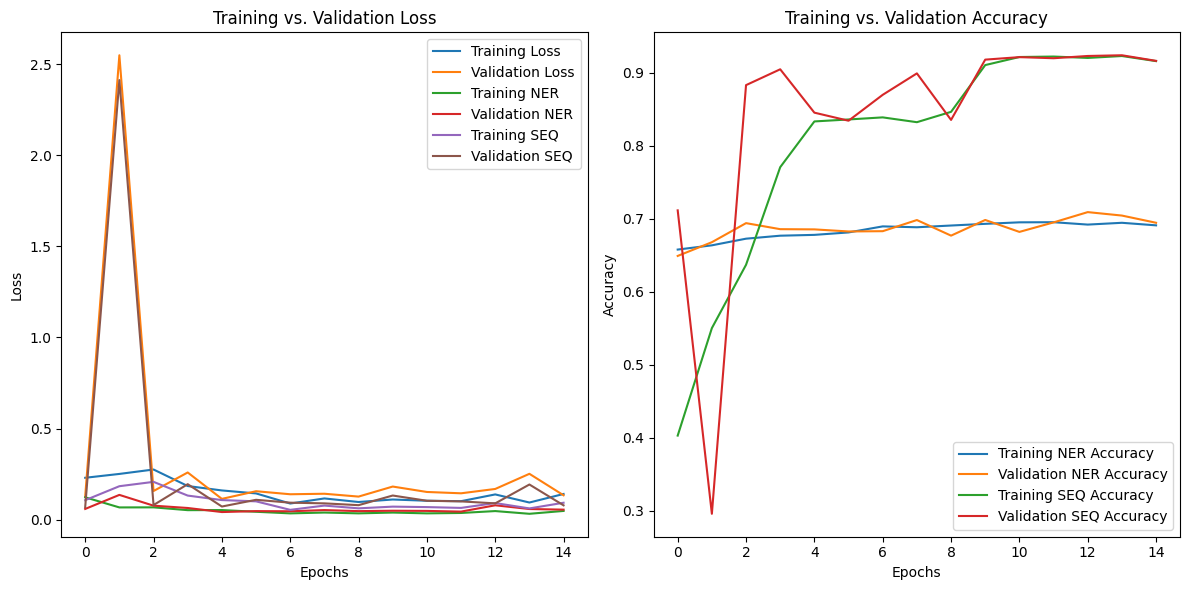

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_classification(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['ner_output_loss'], label='Training NER')
    plt.plot(history.history['val_ner_output_loss'], label='Validation NER')
    plt.plot(history.history['seq_output_loss'], label='Training SEQ')
    plt.plot(history.history['val_seq_output_loss'], label='Validation SEQ')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['ner_output_sparse_categorical_accuracy'], label='Training NER Accuracy')
    plt.plot(history.history['val_ner_output_sparse_categorical_accuracy'], label='Validation NER Accuracy')
    plt.plot(history.history['seq_output_binary_accuracy'], label='Training SEQ Accuracy')
    plt.plot(history.history['val_seq_output_binary_accuracy'], label='Validation SEQ Accuracy')

    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_classification(history)

In [29]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, hamming_loss

def print_classification_performanca(predictions, true_labels, id2tag, max_len = MAX_LEN, binary=False):
    if true_labels.ndim > 2:
        true_labels = true_labels.reshape(true_labels.shape[0], -1)
    if predictions.ndim > 2:
        predictions = predictions.reshape(predictions.shape[0], -1)

    true_labels = true_labels.flatten()
    predictions = predictions.flatten()
    print(f"Shapes: {true_labels.shape} and {predictions.shape}")
    assert true_labels.shape == predictions.shape, "Shape mismatch between labels and predictions"

    print(classification_report(true_labels, predictions,
                                labels=range(len(id2tag)),
                                target_names=list(id2tag.values()), zero_division=0))

    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
                                                                        true_labels, predictions,
                                                                        average='weighted')

    ner_correct = np.sum(predictions == true_labels)
    ner_total = len(true_labels)

    h_loss = hamming_loss(true_labels, predictions)

    print('Accuracy: {:.2f}%'.format(100. * ner_correct / ner_total))
    print('Hamming: {:.2f}%'.format(h_loss))
    print(f"Precision: {100. * weighted_precision:.2f}%, Recall: {100. * weighted_recall:.2f}%,, F1-Score: {100. * weighted_f1:.2f}%")

predictions = model.predict(test_dataset)
predicted_label_indices = np.argmax(predictions[0], axis=-1)
filtered_indices = predicted_label_indices[predicted_label_indices != UNK]
test_ner_labels = np.array(test_ner_labels)
filtered_labels = test_ner_labels[test_ner_labels != UNK]

print_classification_performanca(filtered_indices, filtered_labels, id2tag)

244/244 [==============================] - 35s 98ms/step
Shapes: (498688,) and (498688,)
              precision    recall  f1-score   support

         I-A       0.00      0.03      0.01      1998
        I-CT       0.01      0.02      0.01      3349
        I-DC       0.00      0.00      0.00       710
        I-DI       0.00      0.00      0.00      1764
        I-GC       0.00      0.00      0.00       569
        I-NC       0.02      0.03      0.03      5094
        I-RD       0.00      0.00      0.00      1945
       I-RSS       0.01      0.04      0.01       441
        I-SD       0.01      0.05      0.02       474
        I-SR       0.02      0.04      0.02      3164
        I-SS       0.00      0.00      0.00       458
           O       0.70      0.90      0.79    347284

   micro avg       0.63      0.85      0.72    367250
   macro avg       0.06      0.09      0.07    367250
weighted avg       0.66      0.85      0.75    367250

Accuracy: 62.77%
Hamming: 0.37%
Precision: 4

## Evaluate Sequence Classifier

In [30]:
seq_pred = predictions[1]
seq_labels = np.array(test_seq_labels)
seq_correct = 0
for pred, label in zip(seq_pred, seq_labels):
    pred = tf.nn.sigmoid(pred)
    pred_tags = set(np.where(pred > 0.5)[0])
    label_tags = set(np.where(label == 1)[0])
    if pred_tags == label_tags:
        seq_correct += 1

event_accuracy_ratio = seq_correct / len(seq_labels) if len(seq_labels) > 0 else 0
print(f"Accuracy Ratio: {event_accuracy_ratio:.2f}, correct predictions ({seq_correct} out of {len(seq_labels)})")

Accuracy Ratio: 0.00, correct predictions (6 out of 1948)
